# Moduł odpowiedzialny za transfer stylu

Transfer stylu przygotowany przez autora. Wyniki oraz opis tej implementacji zawarto w pracy.

Elementy, które są ważne pod względem implementacyjnym zostały dokładnie opisane w dodatkowych komórkach. Sekcje możliwe i przystosowane do "bezinwazyjnej" modyfikacji zostały oznaczone **[M]**.

## Przygotowanie bibliotek i narzędzi

### Importowanie bibliotek



In [1]:
import numpy as np
import os
import tensorflow as tf
import time
import functools

import matplotlib.pylab as plt
from PIL import Image
import PIL

import time
import IPython.display as display
from IPython.display import clear_output

### VGG19

Jedną z sieci używanych w transferze jest VGG19. Pobierana jest jej gotowa, przetrenowana wersja z biblioteki keras.

In [2]:
from keras.applications.vgg19 import VGG19

### Przygotowanie GPU

GPU nie jest wymagane, lecz rekomendowane. Uruchomienie transferu na CPU będzie czasochłonne. 

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


### Połączenie z dyskiem google drive



Użycie dysku w podany poniżej sposób jest tylko możliwe podczas korzystania z Google Colaba. 

**Wymagana akcja użytkownika!**

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
drive_path = "/content/drive/MyDrive"
!ls {drive_path} 

 best_mnist.h5	    DomkaMNISTDomka.zip   mnist_v2.h5   results
 BestMnist.zip	    mnist_98.h5		  models        test_data
'Colab Notebooks'   mnist_noau.h5	  MyMnist.zip


## Przygotowanie do wykonania transferu

### **[M]** Przygotowanie sieci
<a name="nets"></a>

Sieci używane w prezentowanym NST są konfigurowalne w dwóch aspektach. 


*   Można dowolnie wybrać konfigurację dwóch sieci odpowiedzialnych za klasyfikację obrazu ze stylem i obrazu głównego.
*   Można wybrać dostępny typ architektury sieci z listy i zastosować go do jednej lub obu klasyfikacji. 





Dostępne sieci, dla konwencj: **model** (dowolny ciąg znaków) _ **accuracy**:

1.   VGG - przetrenowana sieć VGG z kerasa
4. ALEX_TUT - Alex net na podstawie https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad8
5. ALEX_32 -  AlexNet z wykonaną augmentacją
6. ALEX_42  - AlexNet z wykonaną augmentacją
7. ALEX_50  - AlexNet z wykonaną augmentacją
8. MYCONV_56  - autorska sieć konwolucyjna


Powyższe opcje służą do skonfigurowania zmiennej *mode*, którą należy ustawić w sekcji [Parametry](#params). Zmienna *mode* to lista ["TYPE1", "TYPE2"], gdzie TYPE1 i TYPE2 dostępne rodzaje sieci.


Używając opcji ["SAME", *net_type*] sieć *net_type* zostanie użyta do obu klasyfikacji


In [6]:
def prepare_models():
  models = {"content": None, "style": None}
  if isinstance(mode, list):
    if len(mode) == 2:
      if mode[0] == "SAME":
        model = get_model(mode[1])
        models["content"] = model
        models["style"] = model
      else:
        models["content"] = get_model(mode[0])
        models["style"] = get_model(mode[1])
    else:
      raise Exception("Invalid mode format! Use ['modelA', 'modelB']")
  else:
    raise Exception("Invalid mode! Type mode must be a list!")
  
  return models

Aby dodać własną architekturę sieci, należy dodać odpowiednią opcję w *if-ie* z nazwą która będzie używana w zmiennej *mode*. 

Następnie podążając zgodnie ze wzorcem podać kolejno warstwy odpowiedzialne za obraz główny, styl oraz załadować model za pomocą *tf.keras.models.load_model*.

Ważnym jest aby funkcja *get_model* zwracała słownik zgodny z szablonem, tj. posiadała klucze *net*, *clayers* i *slayers*

In [7]:
def get_model(network_name):
  if network_name == "VGG":
    content_layers = ["block5_conv2"]
    style_layers = ["block1_conv1", 
                    "block2_conv1", 
                    "block3_conv1", 
                    "block4_conv1", 
                    "block5_conv1"]
    
    return {"net": VGG19(include_top=False, weights='imagenet'), 
            "clayers": content_layers,
            "slayers": style_layers
            }
  elif "ALEX_" in network_name:
    content_layers = ["conv5"]
    style_layers = ["conv1", 
                    "conv2",
                    "conv3",
                    "conv4"]

    if network_name == "ALEX_32":
      model = tf.keras.models.load_model(os.path.join(drive_path, "models", "myconv2021_alex_32.h5"))
    elif network_name == "ALEX_42":
      model = tf.keras.models.load_model(os.path.join(drive_path, "models", "myconv2021_alex_42.h5"))
    elif network_name == "ALEX_50":
      model = tf.keras.models.load_model(os.path.join(drive_path, "models", "myconv2021_alex_50.h5"))
    elif network_name == "ALEX_TUT":
      model = tf.keras.models.load_model(os.path.join(drive_path, "models", "myconv2021_alex_tut.h5"))
    
    return {"net": model, 
            "clayers": content_layers,
            "slayers": style_layers
            }

  elif network_name == "MYCONV_56":
    content_layers = ["conv4"]
    style_layers = ["conv1", 
                    "conv2",
                    "conv3"]
    model = tf.keras.models.load_model(os.path.join(drive_path, "models", "my_own_conv2021_56.h5"))

    return {"net": model, 
            "clayers": content_layers,
            "slayers": style_layers
            }


### Przygotowanie narzędzi


In [8]:
def tensor_to_image(tensor):
  """Load tensor and convert it to image

  :param tensor: Input tensor to be converted
  :type tensor: tensorflow.python.framework.ops.EagerTensor
  :return: PIL image
  :rtype: PIL.Image.Image 
  """

  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
      tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [9]:
def load_img(path_to_img):
  """Load and prepare input images

  :param path_to_img: Path to image
  :type path_to_img: str
  :return: Image stored as tensor
  :rtype: tensorflow.python.framework.ops.EagerTensor
  """
  
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)  # convert to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) # make sure that tensor has Float32 values

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

In [10]:
def show_images(**data):
  """Show n images stored in data"""

  size = len(data.keys())
  _, axes = plt.subplots(1, size, figsize=(20, 10))
  for index, pair in enumerate(data.items(), 0):
      title, img = pair[0], pair[1]
      if len(img.shape) > 3:
          img = tf.squeeze(img, axis=0)
      if isinstance(axes, np.ndarray):
          ax = axes[index]
      else:
          ax = axes
      ax.set_title(title)
      ax.imshow(img)
  plt.show()    

In [11]:
def save_image(image):
  """Save image to global defined path

  :param image: Image stored as tensor
  :type image: tensorflow.python.framework.ops.EagerTensor

  """

  files = os.listdir(results_dir)
  folder_name = "-".join(mode)
  folder_path = os.path.join(results_dir, folder_name)
  if folder_name not in files:
    os.mkdir(folder_path)
  files = os.listdir(folder_path)
  file_pattern = f"-stylized-{content_weight}-{style_weight}.png"
  counter = 1
  filename = "n0" + file_pattern
  while filename in files:
    filename = "n" + str(counter) + file_pattern
    counter += 1

  tensor_to_image(image).save(os.path.join(results_dir, folder_name, filename))

In [12]:
def compare_results(content_image, style_image, result_image):
  """Show image comparision

  :param content_image: Content image stored as tensor
  :type content_image: tensorflow.python.framework.ops.EagerTensor
  :param style_image: Style image stored as tensor
  :type style_image: tensorflow.python.framework.ops.EagerTensor
  :param result_image: Result image stored as tensor
  :type result_image: tensorflow.python.framework.ops.EagerTensor
  
  """
  fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
  ax.imshow(tensor_to_image(content_image))
  ax.set_title('Content')
  ax1.imshow(tensor_to_image(style_image))
  ax1.set_title("Style")
  ax2.imshow(tensor_to_image(result_image), aspect='equal')
  ax2.set_title("Result")
  plt.show()

## Implementacja NST

Implementacja sieci NST została dokładnie wyjaśniona w pracy.

In [13]:
class NstModel:

  def __init__(self, content_img, style_img, networks, 
               gram_matrix_type="custom"):
    
    """ Nst model

    :param content_image: Image with content
    :type content_image: tensorflow.python.framework.ops.EagerTensor
    :param style_image: Image with style
    :type style_image: tensorflow.python.framework.ops.EagerTensor
    :param networks: Dictionary with style and content networks 
                    (see Przygotowanie sieci)
    :type networks: dict
    :param gram_matrix_type: Gram matrix implemetation type, custom or tf, 
                             default custom
    :type gram_matrix_type: str
    """

    self.style = networks["style"]
    self.content = networks["content"]

    print("Style: ",  self.style["net"].name, "content: ",  self.content["net"].name)

    self.num_content_layers = len(self.content["clayers"])
    self.num_style_layers = len(self.style["slayers"])

    self.content_layers = self.content["clayers"]
    self.style_layers = self.style["slayers"]

    self.style_model = self.get_model(self.style["net"], self.style_layers)
    self.content_model = self.get_model(self.content["net"], self.content_layers)

    if gram_matrix_type == "custom":
      self.gram_matrix = self.custom_gram_matrix
    elif gram_matrix_type == "tf":
      self.gram_matrix = self.tensorflow_gram_matrix
    else:
      raise Exception(f"Invalid gram matrix type: {gram_matrix_type}" + 
                      "Available options are: custom, tf")
    

    # Get feature maps
    self.style_features = self.process_input(style_img)["style"]
    self.content_features = self.process_input(content_img)["content"]


  def get_model(self, network, names):
    outputs = [network.get_layer(name).output for name in names]
    model = tf.keras.Model([network.input], outputs)
    model.trainable = False
    return model

  def process_input(self, input_img):
    if "VGG" in mode:
      input_img = input_img * 255.0
      preprocessed_input = tf.keras.applications.vgg19.preprocess_input(input_img)
    else:
      preprocessed_input = tf.image.per_image_standardization(input_img)
      
    content_outputs = self.content_model(preprocessed_input)
    style_outputs = self.style_model(preprocessed_input)
    style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]
    style_dict = {style_name: value for style_name, value in 
                  zip(self.style_layers, style_outputs)}

    if self.num_content_layers > 1:
      content_dict = {content_name: value for content_name, value in 
                    zip(self.content_layers, content_outputs)}
    else:
      content_dict = {self.content["clayers"][0]: content_outputs}

    return {'content': content_dict, 'style': style_dict}

  def custom_gram_matrix(self, input_tensor):
    channels = int(input_tensor.shape[-1])
    feature_map = tf.reshape(input_tensor, [-1, channels])  # vectorize
    gram = tf.matmul(feature_map, feature_map, transpose_a=True)
    return gram

  def tensorflow_gram_matrix(self, input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


  def calculate_loss(self, outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.reduce_sum([1.0 / self.num_style_layers * \
                                tf.reduce_mean((style_outputs[name]-self.style_features[name])**2) 
                                for name in style_outputs.keys()])
    
    style_loss *= style_weight

    content_loss = tf.reduce_sum([tf.reduce_mean((content_outputs[name]-self.content_features[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / self.num_content_layers

    loss = style_loss + content_loss
    return loss


In [14]:
def prepare_model_and_data(initial_result, content_image, style_image, 
                           gram_matrix_type):
  """Prepare initial result and NstModel
  
  :param initial_result: Initial result generation type, content or noise
  :type initial_result: str
  :param content_image: Image with content
  :type content_image: tensorflow.python.framework.ops.EagerTensor
  :param style_image: Image with style
  :type style_image: tensorflow.python.framework.ops.EagerTensor
  :param gram_matrix_type: Gram matrix implemetation type, custom or tf
  :type gram_matrix_type: str
  :return: Tuple with initial result and nst model
  :rtype: tuple

  """

  if initial_result == "noise":
    initializer = tf.random_normal_initializer()
    result_image = tf.Variable(initializer(shape=content_image.shape, dtype=tf.float32))
  elif initial_result == "content":
    result_image = tf.Variable(content_image)
    tensor_to_image(result_image)
  else:
    raise Exception(f"Invalid initial_result {initial_result}!"+
                    "Available options are: noise, content")
    
  networks = prepare_models()
  nst = NstModel(content_image, style_image, networks, gram_matrix_type)
  return result_image, nst


## **[M]** Parametry
<a name="params"></a>

W tej sekcji użytkownik może zbadać wpływ różnych parametrów na działanie sieci. Wszystkie komórki znajdujące w obrębie sekcji *Parametry* mogą zostać zmodyfikowane.

### Obrazy wejściowe

Wczytanie obrazów wejściowych wymaga skonfigurowania 3 typów parametrów. 

*   _dir - ścieżka do katalogu w którym znajdują się zdjęcia (*img_dir* -> obrazy wejściowe, *results_dir* -> miejsce w którym zostaną zapisane wyniki)
*  _img_name - nazwa obrazu ze stylem (*style_img_name*) i obrazu głównego (*content_img_name*)
*  initial_result - rozwiązanie początkowe. Może zostać ustawione na obraz główny ("content") lub losowo wygenerowany szum ("noise").



In [22]:
img_dir = os.path.join(drive_path, "test_data")
results_dir = os.path.join(drive_path, "results")

content_img_name = "me2.jpg"
style_img_name = "style3.jpg"

initial_result = "content"  # content or noise

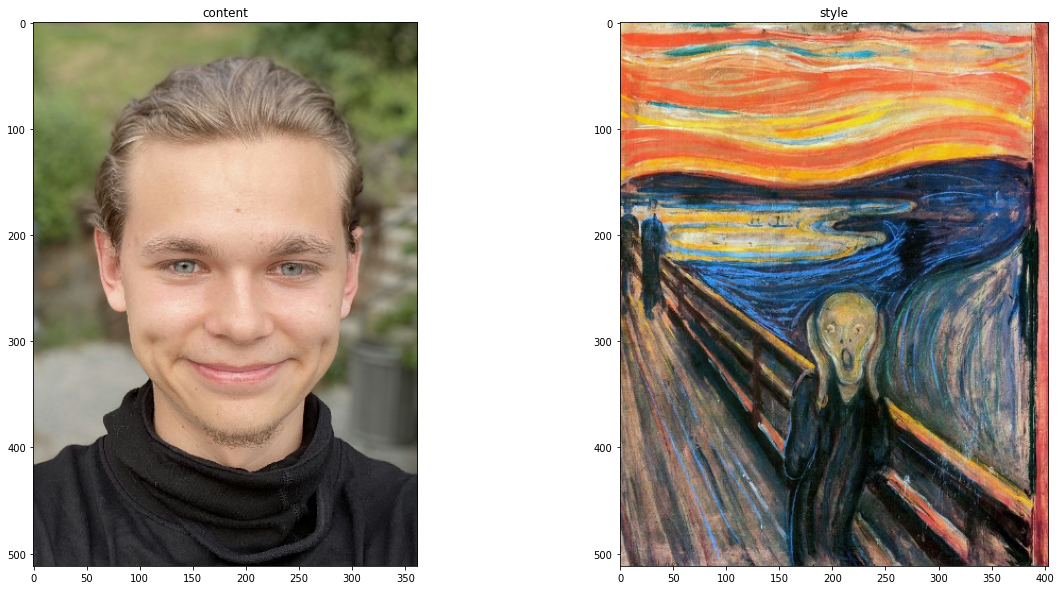

In [23]:
content_path = os.path.join(img_dir, content_img_name)
style_path = os.path.join(img_dir, style_img_name)

content_image = load_img(content_path)
style_image = load_img(style_path)
show_images(content=content_image, style=style_image)

### Wybór sieci do klasyfikacji

Wybór sieci klasyfikującej na podstawie listy możliwości przedstwionej w sekcji [Przygotowanie sieci](#nets).

In [17]:
mode = ["SAME", "VGG"]  # content and style networks are VGG19
# mode = ["ALEX_50", "MYCONV_56"] # content - VGG19, style - MYCONV_50 
# mode = ["VGG", "MYCONV_56"] # content - MYCONV_75, style - MYCONV_50

### Parametry związane z NST

Możliwe do konfiguracji są także następujące parametry:


*   style_weight - parametr $\alpha$, współczynnik wpływu obrazu ze stylem na rozwiązanie (najlepiej $[10^{-10}, 10^{10}]$)
*   content_weight parametr $\beta$, współczynnik wpływu obrazu głównego na rozwiązanie (najlepiej $[10^{-10}, 10^{10}]$)
*   gram_matrix_type - typ implementacji macierzy grama, możliwości to "custom" - autorska implementacja w oparciu o publikację [Gatysa](#biblio), "tf" implementacja macierzy Grama zaproponowana przez tensorflow.
*   epochs i steps_per_epoch - czas trwania transferu, co *steps_per_epoch* wyświetlany jest obraz, o ile taka opcja została włączona
*   opt - optymalizator użyty w transferze - modyfikowalne są jego parametry i możliwa jest jego całkowita zamiana (przy czym ADAM jest rekomendowany)




In [18]:
style_weight =  1e4 # alpha ideal 1e-2
content_weight =  1e-4 # beta ideal 1e4 -> big content low style (more content)
gram_matrix_type = "custom"  # custom or tf

epochs = 10
steps_per_epoch = 50

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## Transfer stylu


Sekcja odpowiedzialna za przeprowadzenie transferu. Zmiana parametrów w sekcji [Parametry](#params) wymaga restartu komórek z kodem znajdujących się w tej sekcji.

### Funkcje pomocnicze

In [24]:
@tf.function()
def train_step(image, nst):
  total_variation_weight = 60
  
  with tf.GradientTape() as tape:
    outputs = nst.process_input(image)
    loss = nst.calculate_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)  # renoising

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  return loss

In [25]:
def train(display_progress=True):
  """Main function for training"""
  result_image, nst = prepare_model_and_data(initial_result, content_image, 
                                             style_image, gram_matrix_type)
  start = time.time()
  step = 0
  for n in range(epochs):
      for m in range(steps_per_epoch):
          step += 1
          train_step(result_image, nst)
          print(".", end="")
      clear_output(wait=True)
      print(f"Train step: {step}.")
      if display_progress:
        display.display(tensor_to_image(result_image))
  end = time.time()
  print("Total time: {:.1f}".format(end-start))
  return result_image

### Uruchomienie transferu


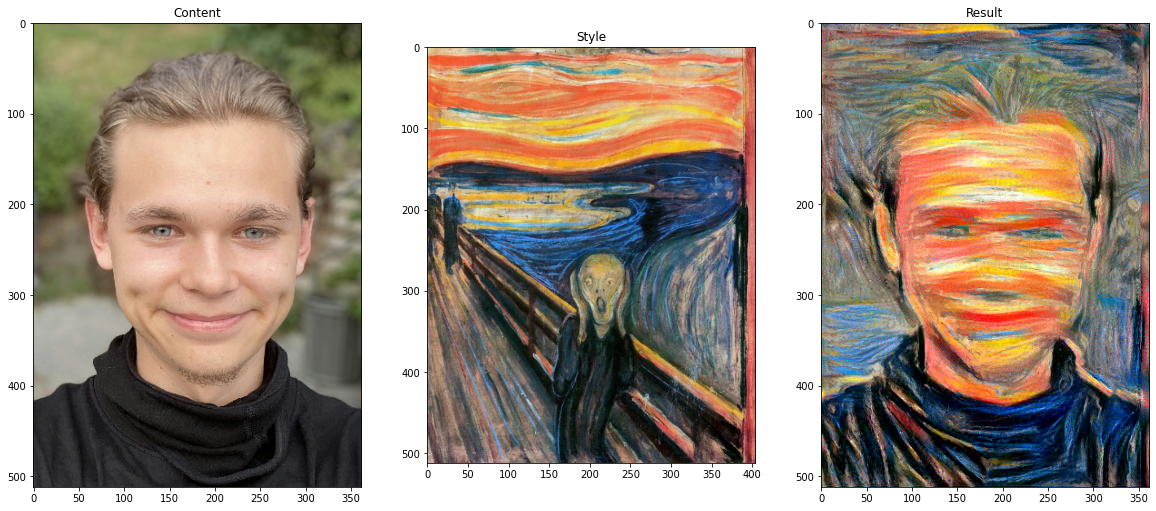

In [26]:
# if "Could not find variable error" appears reload train_step cell
result_image = train()
clear_output(wait=True)
compare_results(content_image, style_image, result_image)
save_image(result_image)

## Bibliografia

1.    L.  A.  Gatys,  A.  S.  Ecker,  M.  Bethge.A  neural  algorithm  of artistic style.  *CoRR,abs/1508.06576*, 2015.
2.   https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee
3. https://www.tensorflow.org/tutorials/generative/style_transfer

